In [30]:
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    MeshcatVisualizer,
    Parser,
    Simulator,
    InverseDynamicsController,
    LeafSystem,
    JointSliders,
    Meshcat,
    FirstOrderLowPassFilter,
    VectorLogSink
)
import numpy as np
from manipulation.utils import RenderDiagram
from robot import Robot
from dynamixel import Dynamixel
import time


In [146]:
class TruncateVec(LeafSystem):
    def __init__(self, input_dims, output_dims):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("input", input_dims)
        self.DeclareVectorOutputPort("output", output_dims, self.CalcOutput)
        self.input_dims = input_dims
        self.output_dims = output_dims

    def CalcOutput(self, context, output):
        full_state = self.get_input_port().Eval(context)
        output.SetFromVector(full_state[:self.output_dims]) # TODO: support arbitrary slicing

class ZeroExtendVec(LeafSystem):
    def __init__(self, input_dims, output_dims):
        LeafSystem.__init__(self)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.DeclareVectorInputPort("input", input_dims)
        self.DeclareVectorOutputPort("output", output_dims, self.CalcOutput)

    def CalcOutput(self, context, output):
        input_vec = self.get_input_port(0).Eval(context)
        output.SetFromVector(np.hstack((input_vec, [0] * (self.output_dims - self.input_dims))))


class Identity(TruncateVec):
    def __init__(self, dims):
        TruncateVec.__init__(self, dims, dims)
        

In [3]:
def build_sim_robot(meshcat):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-2)
    # Note that we parse into both the plant and the scene_graph here.
    robot_model = Parser(plant, scene_graph).AddModelsFromUrl(
            "file:///Users/raghav/Documents/projects/robot_arm/onshape-to-robot-examples/low-cost-robot/robot-post-processed.urdf"
    )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("link_0"))
    plant.Finalize()
    
    low_cost_robot = plant.GetModelInstanceByName("onshape")
        
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [10] * plant.num_positions()
    static_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
    extend_pos = builder.AddSystem(ZeroExtendVec(6, 12))
    truncate_state = builder.AddSystem(TruncateVec(12, 6))

    builder.ExportInput(extend_pos.get_input_port(), "desired_position")
    builder.ExportOutput(truncate_state.get_output_port(), "measured_position")

    # Connect the robot state to the ID controller
    builder.Connect(
        plant.get_state_output_port(low_cost_robot),
        static_controller.get_input_port_estimated_state(),
    )

    # Connect the ID output to the plant
    builder.Connect(
        static_controller.get_output_port_control(), 
        plant.get_actuation_input_port()
    )

    builder.Connect(
        extend_pos.get_output_port(),
        static_controller.get_input_port(1)
    )

    builder.Connect(
        plant.get_state_output_port(low_cost_robot),
        truncate_state.get_input_port()
    )

    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    diagram.set_name("low-cost-robot (sim)")
    return diagram, plant


In [153]:
class LowCostRobot(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        dynamixel = Dynamixel.Config(
            baudrate=57_600,
            device_name='/dev/tty.usbmodem578E0211421'
        ).instantiate()
        self._robot = Robot(dynamixel)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._plant_robot = plant.GetModelInstanceByName("onshape")
        # self._robot._disable_torque()
        pos = self._robot.read_position()
        if not pos:
            raise Exception("Could not connect to bot")

        # Slowly move the robot to the home position
        self._home_position = [2018, 996, 1874, 1709, 2067, 2367]
        self._slow_move_to_pos(self._home_position)

        self.DeclareVectorInputPort("desired_position", 6)
        self.DeclareVectorOutputPort("measured_position", 6, self.CalcOutput)

    def _slow_move_to_pos(self, desired_position):
        current_position = self._robot.read_position()
        # we want to move a maximum of +100 or -100 in each step
        diff_to_home = [desired_position[i] - current_position[i] for i in range(6)]
        max_diff = max([abs(diff) for diff in diff_to_home])
        time_window = 1
        time_per_step = 0.1
        steps = int(time_window / time_per_step)
        for i in range(steps):
            for j in range(6):
                current_position[j] += int(diff_to_home[j] / steps)
            self._robot.set_goal_pos(current_position)
            time.sleep(time_per_step)
        

    def CalcOutput(self, context, outputs):
        # should i be setting the plant pos here? hmmm -- no because teh pinv controller does that to calculate the jacobian. (future raghav) eep yes, don't do it in the jacobian why!!
        # first sanitize the input port. just constrain everything from pi/ 3 to -pi / 3.
        # eventually constrain based on fk result
        # next convert [-pi, pi] to [0, 4096]
        # desired position shouldn't be too far from current position (no difference of greater than 100)

        desired_position_float: np.ndarray = self.get_input_port().Eval(context) # type: ignore

        desired_position = np.clip(desired_position_float, -np.pi / 3, np.pi / 3)
        desired_position = (desired_position + np.pi) / (2 * np.pi) * 4096
        desired_position = desired_position.astype(int)

        measured_position = self._robot.read_position()
        current_pos = np.array(self._get_measured_pos_as_angles())
        # self._plant.SetPositions(context, self._plant_robot, current_pos)
        # print(f"Current pos {current_pos}, desired pos as float {desired_position_float}, desired_position {desired_position}")
        # import ipdb; ipdb.set_trace()
        num_movable_joints = 1
        should_move = False
        for i in range(num_movable_joints):
            abs_diff = abs(measured_position[i] - desired_position[i])
            if abs_diff > 100:
                print("Desired position too far from current position, skipping")
                
                outputs.SetFromVector(current_pos)
                self._robot.set_goal_pos(measured_position)
                return
                
            elif abs_diff > 10:
                # only command a new position if there is somewhere new to move to
                should_move = True

        if should_move:
            # you can't reuse the measured position list for the rest of the joints because it's an unstable system and will droop!!
            commanded_position = list(desired_position[:num_movable_joints]) + list(self._home_position[num_movable_joints:])
            print(commanded_position)
            self._robot.set_goal_pos(commanded_position) # gripper is always open for now.
        outputs.SetFromVector(np.array(self._get_measured_pos_as_angles()))

    def _get_measured_pos_as_angles(self):
        measured_position = self._robot.read_position()
        return np.array(measured_position) / 4096 * 2 * np.pi - np.pi

    def test_conn(self):
        pos = self.robot.read_position()
        if not pos:
            raise Exception("Could not connect to bot")

    @property
    def robot(self):
        return self._robot


real_robot = None

def build_real_robot(meshcat):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-2)
    # Note that we parse into both the plant and the scene_graph here.
    robot_model = Parser(plant, scene_graph).AddModelsFromUrl(
            "file:///Users/raghav/Documents/projects/robot_arm/onshape-to-robot-examples/low-cost-robot/robot-post-processed.urdf"
    )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("link_0"))
    plant.Finalize()

    # Wire up the plant to be position controlled? This is annoying, I'd rather just rely on "real" dynamics and somehow be able to set the plant positions correctly.
    low_cost_robot = plant.GetModelInstanceByName("onshape")
    kp = [100] * plant.num_positions()
    ki = [1] * plant.num_positions()
    kd = [10] * plant.num_positions()
    static_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
    # extend_measured_pos = builder.AddSystem(ZeroExtendVec(6, 12))
    extend_desired_pos = builder.AddSystem(ZeroExtendVec(6, 12))
    desired_pos = builder.AddSystem(Identity(6))

    

    # Connect the ID output to the plant
    builder.Connect(
        static_controller.get_output_port_control(), 
        plant.get_actuation_input_port()
    )

    builder.Connect(
        extend_desired_pos.get_output_port(),
        static_controller.get_input_port(1)
    )

    # builder.Connect(
    #     extend_measured_pos.get_output_port(),
    #     static_controller.get_input_port_estimated_state()
    # )

    builder.Connect(
        plant.get_state_output_port(low_cost_robot),
        static_controller.get_input_port_estimated_state(),
    )

    
    
    # build the leaf system that is the robot
    global real_robot
    real_robot = builder.AddSystem(LowCostRobot(plant))
    
    builder.Connect(desired_pos.get_output_port(), extend_desired_pos.get_input_port()) # desired state
    builder.Connect(desired_pos.get_output_port(), real_robot.get_input_port())
    # builder.Connect(real_robot.get_output_port(), extend_measured_pos.get_input_port()) # measured state
    
    builder.ExportInput(desired_pos.get_input_port(), "desired_position")
    builder.ExportOutput(real_robot.get_output_port(), "measured_position")
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    
    diagram = builder.Build()
    diagram.set_name("low-cost-robot (real)")
    return diagram, plant
    


In [154]:
def teleop_example(meshcat):    
    # (robot_diagram, plant) = build_sim_robot(meshcat)
    (robot_diagram, plant) = build_real_robot(meshcat)
    
    builder = DiagramBuilder()
    teleop = builder.AddSystem(JointSliders(meshcat=meshcat, plant=plant))
    builder.AddSystem(robot_diagram)

    num_joints = 6
    lp_filter = builder.AddSystem(FirstOrderLowPassFilter(
        time_constant=1.0, size=num_joints))

     
    builder.Connect(
        teleop.get_output_port(0),
        lp_filter.get_input_port(0),
    )
    builder.Connect(lp_filter.get_output_port(0), robot_diagram.get_input_port(0))

    # you need a sink for teh sim to do anything SMFH.
    log_sink = builder.AddSystem(VectorLogSink(6))
    builder.Connect(robot_diagram.get_output_port(0), log_sink.get_input_port())

    diagram = builder.Build()
    
    RenderDiagram(diagram, max_depth=2)
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    
    simulator.AdvanceTo(1e-6)
    robot_context = robot_diagram.GetMyMutableContextFromRoot(context)
    initial_plant_pos = robot_diagram.get_output_port().Eval(robot_context)
    teleop.SetPositions(initial_plant_pos)
    lp_filter.set_initial_output_value(diagram.GetMutableSubsystemContext(
        lp_filter, simulator.get_mutable_context()), initial_plant_pos)
    simulator.set_publish_every_time_step(False)
    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(np.inf)



disabling torque for servos [0, 1, 2, 3, 4, 5]
disabling torque for servos [0, 1, 2, 3, 4, 5]
enabling torque for servos [0, 1, 2, 3, 4, 5]


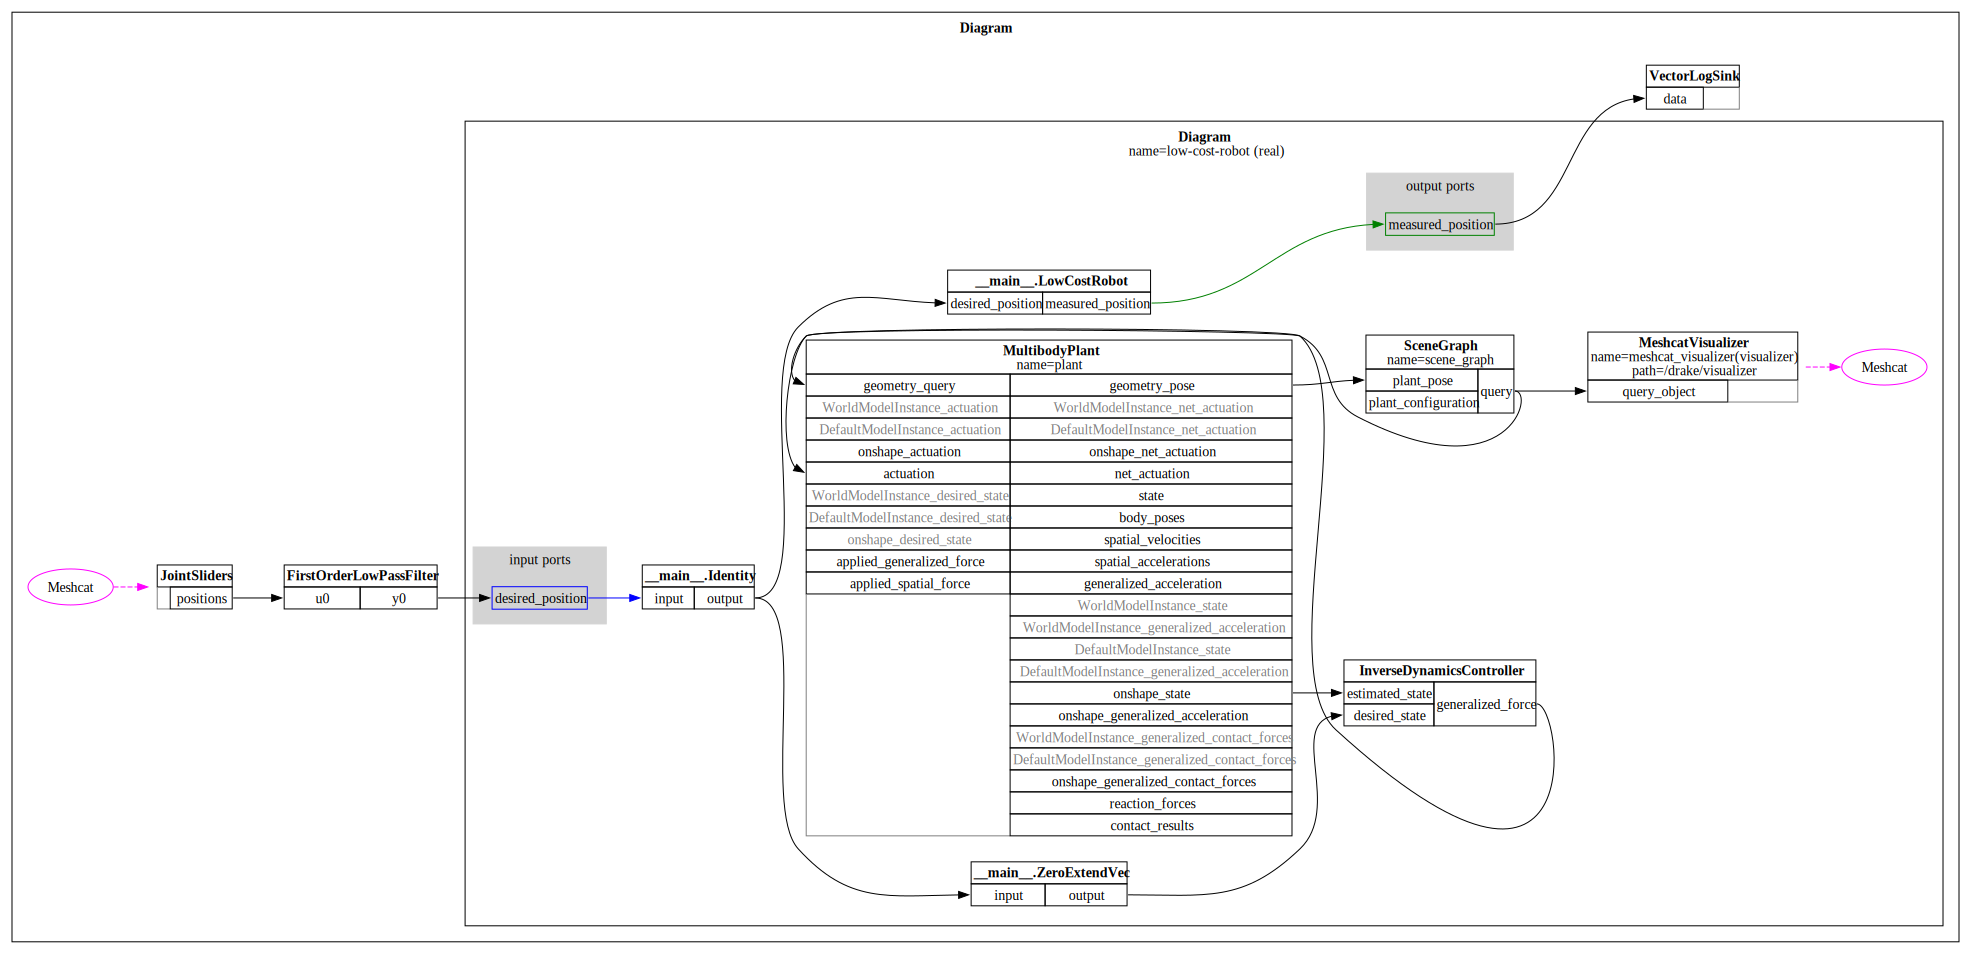

[2048, 996, 1874, 1709, 2067, 2367]
[2048, 996, 1874, 1709, 2067, 2367]
[2037, 996, 1874, 1709, 2067, 2367]
[2020, 996, 1874, 1709, 2067, 2367]
[2017, 996, 1874, 1709, 2067, 2367]
[2012, 996, 1874, 1709, 2067, 2367]
[2006, 996, 1874, 1709, 2067, 2367]
[1997, 996, 1874, 1709, 2067, 2367]
[1994, 996, 1874, 1709, 2067, 2367]
[1990, 996, 1874, 1709, 2067, 2367]
[1983, 996, 1874, 1709, 2067, 2367]
[1975, 996, 1874, 1709, 2067, 2367]
[1971, 996, 1874, 1709, 2067, 2367]
[1961, 996, 1874, 1709, 2067, 2367]
[1960, 996, 1874, 1709, 2067, 2367]
[1954, 996, 1874, 1709, 2067, 2367]
[1950, 996, 1874, 1709, 2067, 2367]
[1947, 996, 1874, 1709, 2067, 2367]
[1941, 996, 1874, 1709, 2067, 2367]
[1939, 996, 1874, 1709, 2067, 2367]
[1934, 996, 1874, 1709, 2067, 2367]
[1928, 996, 1874, 1709, 2067, 2367]
[1920, 996, 1874, 1709, 2067, 2367]
[1908, 996, 1874, 1709, 2067, 2367]
[1907, 996, 1874, 1709, 2067, 2367]
[1901, 996, 1874, 1709, 2067, 2367]
[1894, 996, 1874, 1709, 2067, 2367]
[1888, 996, 1874, 1709, 2067

KeyboardInterrupt: 

In [155]:
try:
    meshcat
except NameError:
    meshcat = Meshcat(port=7002)

meshcat.Delete()
meshcat.DeleteAddedControls()
    

teleop_example(meshcat)

In [79]:
real_robot.robot.read_position()

failed to read position!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


[0, 0, 0, 0, 0, 0]

In [76]:
real_robot.robot.set_goal_pos([1365, 1329, 1459, 1120, 1249, 1992])